In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
tf.__version__

'1.3.0'

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
data.test.cls=np.array([label.argmax() for label in data.test.labels])

In [8]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

In [9]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

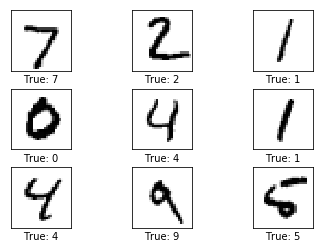

In [12]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)


In [19]:
x=tf.placeholder(tf.float32,[None,img_size_flat])

In [20]:
y_true=tf.placeholder(tf.float32,[None,num_classes])

In [21]:
y_true_cls=tf.placeholder(tf.int64,[None])

In [23]:
weights=tf.Variable(tf.zeros([img_size_flat,num_classes]))
biases=tf.Variable(tf.zeros([num_classes]))

In [24]:
logits=tf.matmul(x,weights)+biases

In [25]:
y_pred=tf.nn.softmax(logits)

In [26]:
y_pred_cls=tf.argmax(y_pred, axis=1)

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_true)

In [28]:
cost = tf.reduce_mean(cross_entropy)

In [32]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [34]:
cross_prediction=tf.equal(y_pred_cls,y_true_cls)

In [35]:
accuracy=tf.reduce_mean(tf.cast(cross_prediction,tf.float32))

In [49]:
session=tf.Session()

In [50]:
session.run(tf.global_variables_initializer())

In [51]:
batch_size = 100

In [52]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

In [53]:
feed_dict_test = {x: data.test.images,y_true: data.test.labels,y_true_cls: data.test.cls}

In [54]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [55]:
def print_confusion_matrix():
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the predicted classifications for the test-set.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Make various adjustments to the plot.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [72]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([cross_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [73]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [74]:
print_accuracy()

Accuracy on test-set: 9.8%


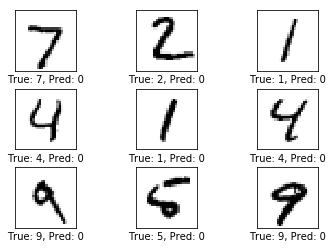

In [75]:
plot_example_errors()

In [76]:
optimize(num_iterations=1)

In [77]:
print_accuracy()

Accuracy on test-set: 20.4%


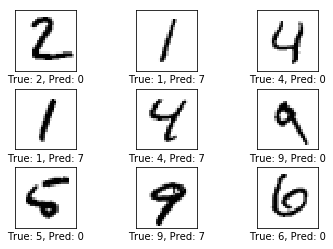

In [78]:
plot_example_errors()

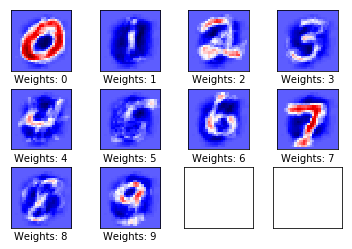

In [79]:
plot_weights()

In [80]:
# We have already performed 1 iteration.
optimize(num_iterations=9)

In [81]:
print_accuracy()

Accuracy on test-set: 74.2%


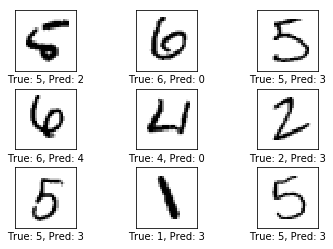

In [82]:
plot_example_errors()

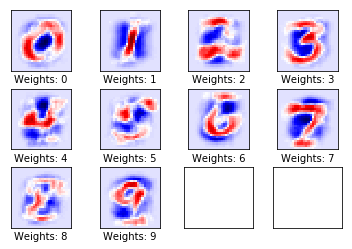

In [83]:
plot_weights()

In [84]:
# We have already performed 10 iterations.
optimize(num_iterations=990)

In [85]:
print_accuracy()

Accuracy on test-set: 91.8%


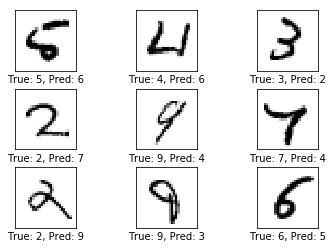

In [86]:
plot_example_errors()

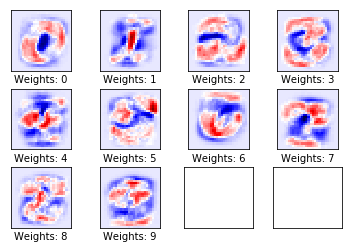

In [87]:
plot_weights()

[[ 960    0    1    1    0    4   11    1    2    0]
 [   0 1103    2    2    1    2    4    2   19    0]
 [   9   10  893   23   13    2   19   14   42    7]
 [   3    0   12  939    0   10    6   11   23    6]
 [   1    1    2    1  914    0   13    2   10   38]
 [  10    3    3   54    9  727   24    7   47    8]
 [   8    3    2    2   10    7  921    1    4    0]
 [   3    7   21    9    8    1    0  941    3   35]
 [   7    6    6   23    9   17   11   12  882    1]
 [  10    6    1   11   42    5    1   21   10  902]]


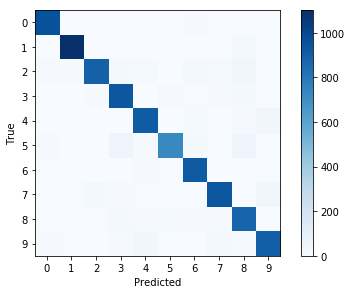

In [88]:
print_confusion_matrix()

In [89]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

In [90]:
#You may want to backup this Notebook before making any changes.

#1.Change the learning-rate for the optimizer.
#2.Change the optimizer to e.g. AdagradOptimizer or AdamOptimizer.
#3.Change the batch-size to e.g. 1 or 1000.
#4.How do these changes affect the performance?
#5.Do you think these changes will have the same effect (if any) on other classification problems and mathematical models?
#6.Do you get the exact same results if you run the Notebook multiple times without changing any parameters? Why or why not?
#7.Change the function plot_example_errors() so it also prints the logits and y_pred values for the mis-classified examples.
#8.Use sparse_softmax_cross_entropy_with_logits instead of softmax_cross_entropy_with_logits. This may require several changes to multiple places in the source-code. Discuss the advantages and disadvantages of using the two methods.
#9.Remake the program yourself without looking too much at this source-code.
